# To be continued or discontinued: investigating secret formula for successful movie franchise
This notebook contains in-depth analysis and visualization for our project. Some figures in the blog post is taken from this notebook.

## Data loading and preprocessing

__Delete unused import before submission__

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

# custom functions
from src.data.utils import get_franchise_movies, get_inflation_rate, get_movie, clean_character_metadata, custom_autopct, create_num_racial_groups, get_tree_df
from src.utils.plotting import plot_geo_piecharts
from src.utils.importance import run_importance
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We'll start by loading the character data and drop rows if any of the columns in `COL_FOR_DROPNA` is missing. This will make the following analysis easier without dropping too many rows (55467/395202 dropped).

__DO NOT EDIT THE LOADING ORDER OF `character_df`, `movies_df_raw`, `franchise_df` AND `movies_no_franchise_df`.__

In [5]:
COL_NAMES = [
    'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 
    'Actor_date_of_birth', 'Actor_gender', 'Actor_height_m', 'Actor_ethnicity_Freebase_ID', 
    'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_actor_map_ID', 
    'Freebase_character_ID', 'Freebase_actor_ID'
]
COL_FOR_DROPNA = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date',
                  'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID',
                  'Freebase_actor_ID']
RANDOM_STATE = 42

In [6]:
# load and prepare character_df
character_df = pd.read_csv('data/character.metadata.tsv', names=COL_NAMES, sep='\t')
character_df = clean_character_metadata(character_df, mapping_path='data/ethnicity_mapping.csv', columns=COL_FOR_DROPNA)

#loading the inflation rate data set from the columbia bank
inflation_rate_df=get_inflation_rate()
#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')
movies_df_raw = create_num_racial_groups(movies_df_raw, character_df)
#Data frame with all the movies with preprocessing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')
#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

# create a new column to check if the movie is part of a franchise
character_df["is_in_franchise"] = character_df["Wikipedia_movie_ID"].isin(franchise_df["Wikipedia movie ID"])

#Data frame of only the franchise name and their characteristics
# franchise_data_df = get_franchise_data(franchise_df)

# Drop franchises where any movie in the franchise does not have a release date
# franchise_df_2 = franchise_df.groupby('collection_id').filter(lambda x: x['Movie release date'].notna().all())
# print("Number of movies with all movies having release dates : ", len(franchise_df_2))
# print(franchise_df)

Dropping character data rows with missing values in any of ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID', 'Freebase_actor_ID'].
Number of rows dropped: 55467
395202 rows remaining.
Running sentiment analysis...


100%|██████████| 52034/52034 [00:04<00:00, 10890.82it/s]


## Data presentation 

### General numerical data 

In [7]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")
print(f"Number of movies in the entire data set: {len(movies_df['collection_id'])}")
print(f"Number of movies not in a collections: {len(movies_no_franchise_df)}")

count    1592.00000
mean        3.24309
std         3.75448
min         2.00000
25%         2.00000
50%         2.00000
75%         3.00000
max        66.00000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5163
Number of movies in the entire data set: 81740
Number of movies not in a collections: 75558


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 
Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).

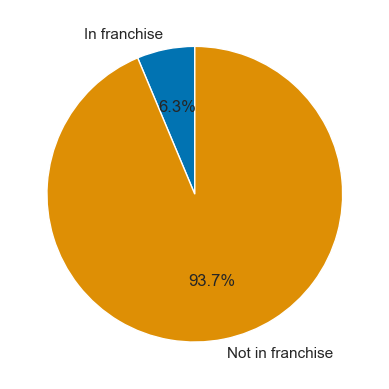

In [8]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

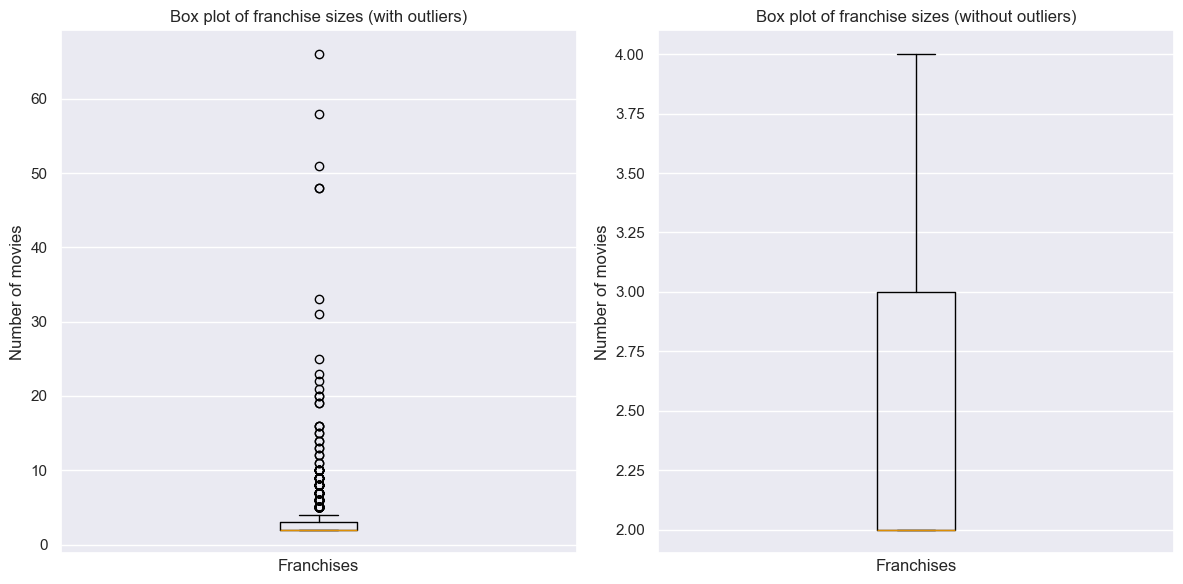

In [9]:
# Plot the box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot with outliers
axes[0].boxplot(franchise_counts)
axes[0].set_title('Box plot of franchise sizes (with outliers)')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Franchises')
axes[0].set_xticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)')
axes[1].set_ylabel('Number of movies')
axes[1].set_xlabel('Franchises')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

### Diversity and franchise movies

In this part, we will particularly tackle Q2-3 of our research questions. That is:

> 2-3: Do actors of certain ethnicity/gender groups appear more or less commonly in franchise movies? Are they depicted positively (hero/heroine) or negatively (villain) in the movie?

#### Actor gender distribution
To begin with, we'll look at actor gender distribution of franchise and non-franchise movies.

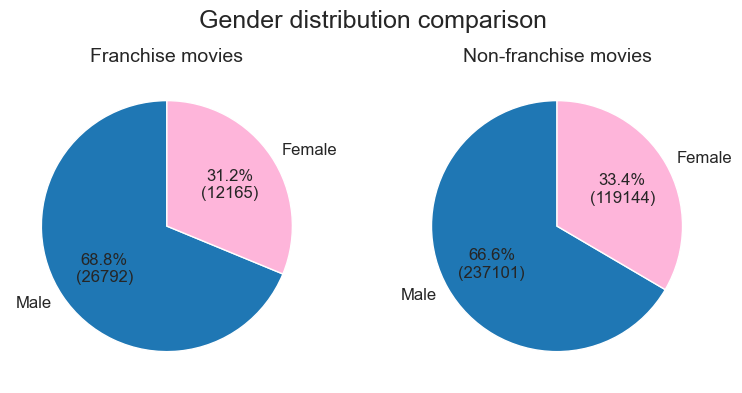

In [10]:
# Calculate the proportion of each gender for character_df
gender_proportion_non_fr = character_df[~character_df['is_in_franchise']]['Actor_gender'].value_counts()
# Calculate the proportion of each gender for fr_character_df
gender_proportion_franchise = character_df[character_df["is_in_franchise"]]['Actor_gender'].value_counts()
# Plot the gender proportions as pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Plot for fr_character_df
gender_proportion_franchise.plot(kind='pie', ax=axes[0], autopct=custom_autopct(gender_proportion_franchise),
                                 startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'],
                                 fontsize=12)
axes[0].set_ylabel('')
axes[0].set_title('Franchise movies', fontsize=14)

# Plot for character_df
gender_proportion_non_fr.plot(kind='pie', ax=axes[1], autopct=custom_autopct(gender_proportion_non_fr),
                           startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'], fontsize=12)
axes[1].set_ylabel('')
axes[1].set_title('Non-franchise movies', fontsize=14)
# Set overarching title
fig.suptitle('Gender distribution comparison', fontsize=18)
plt.tight_layout()
plt.show()

It seems that actor gender distribution remains the same for franchise and non-franchise movies. This is unsurprising as most of us can agree that there are particulalry many female characters in franchise movies than non-franchise movies, at least anecdotally.

#### Racial group
Next, we shift our focus to ethnicity groups. Contrary to actor gender information, actor ethnicity is not available for the majority of actors (available for 99719/395202 $\approx$ 25.2%). Upon observing the dataset, we hypothesized that the actors with known ethnicity are those with more publicity and therefore, more likely to play main roles in the movies. The ethnicity distribution of these main actors can be representative of which racial group is more or less featured in the movie. Bearing this in mind, we will proceed to visualize actors' racial group distribution for franchise and non-franchise movies.

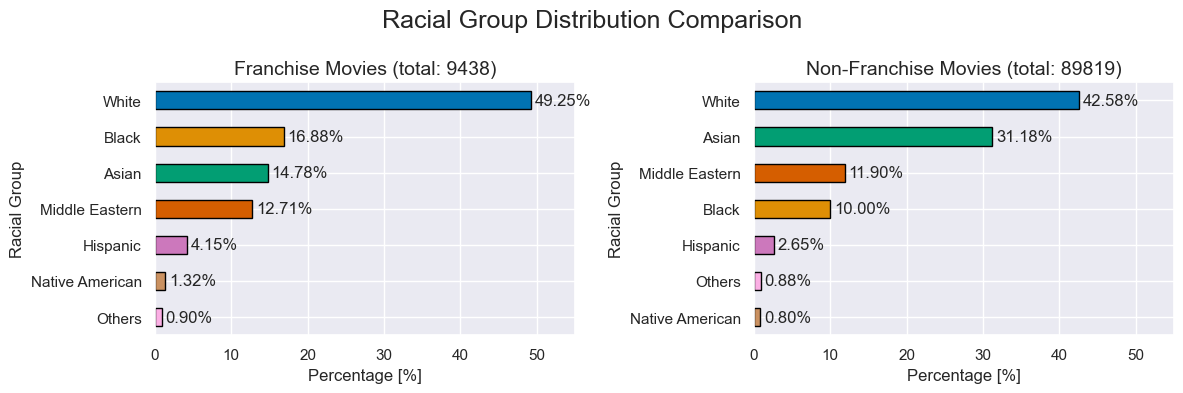

In [11]:
# Define colors for racial groups
colors = dict(zip(['White', 'Black', 'Asian', 'Middle Eastern', 'Hispanic', 'Native American', 'Others'], sns.color_palette("colorblind", 7)))

# Calculate the percentage of each racial group for franchise and non-franchise movies
racial_proportion_franchise = character_df[character_df["is_in_franchise"]].value_counts("racial_group")
racial_proportion_non_franchise = character_df[~character_df['is_in_franchise']].value_counts("racial_group")
percentage_fr = (racial_proportion_franchise / racial_proportion_franchise.sum()) * 100
percentage_non_fr = (racial_proportion_non_franchise / racial_proportion_non_franchise.sum()) * 100
fr_count = racial_proportion_franchise.sum()
non_fr_count = racial_proportion_non_franchise.sum()

# Plot the racial percentages as horizontal bar charts side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for franchise movies
bars_fr = percentage_fr.plot(kind='barh', ax=axes[0], color=[colors[group] for group in percentage_fr.index], edgecolor='black')
axes[0].set_title(f'Franchise Movies (total: {fr_count})', fontsize=14)
axes[0].set_xlabel('Percentage [%]')
axes[0].set_ylabel('Racial Group')
axes[0].invert_yaxis()  # Inverse y-axis
axes[0].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_fr.patches:
    axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center')

# Plot for non-franchise movies
bars_non_fr = percentage_non_fr.plot(kind='barh', ax=axes[1], color=[colors[group] for group in percentage_non_fr.index], edgecolor='black')
axes[1].set_title(f'Non-Franchise Movies (total: {non_fr_count})', fontsize=14)
axes[1].set_xlabel('Percentage [%]')
axes[1].set_ylabel('Racial Group')
axes[1].invert_yaxis()  # Inverse y-axis
axes[1].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_non_fr.patches:
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center', fontsize=12)

# Set overarching title
fig.suptitle('Racial Group Distribution Comparison', fontsize=18)

plt.tight_layout()
plt.show()

The percentages in each of the plots above sum up to 100%. Notice that compared to non-franchise movies, franchise movies have fewer percentage of Asian actors (Franchise: 14.78%, Non-franchise: 31.18%). The two pie charts on the righthand side of the figure below, however, show that the proporitions of movies from Asia (excluding Russia, Oceania and Middle East) in franchise and non-franchise movies are not as different as the disparity observed earlie in Asian actor percentages.

This means that the disparity in the percentage of Asian actors comes from factors other than the movie production location. It is hard to identify the exact cause for this from our analysis only, but a potential confounding factor can be difference in genres: perhaps certain movie genres are more likely to be franchised which are underrepresented by Asian actors.

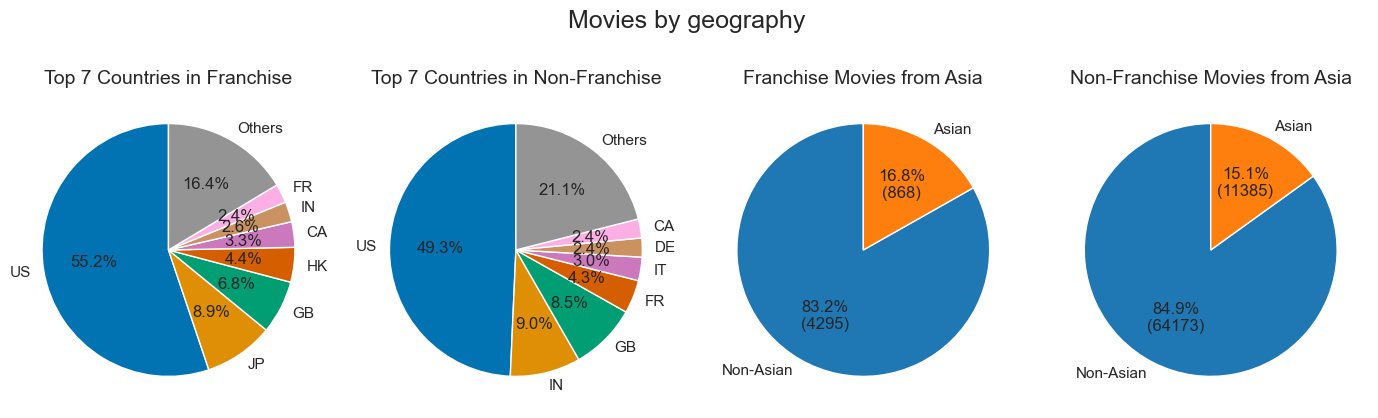

In [12]:
plot_geo_piecharts(movies_df, franchise_df, movies_no_franchise_df)

#### Sentimental analysis

Comment for word cloud - what are the typical adjectives used to positively or negatively describe the character?

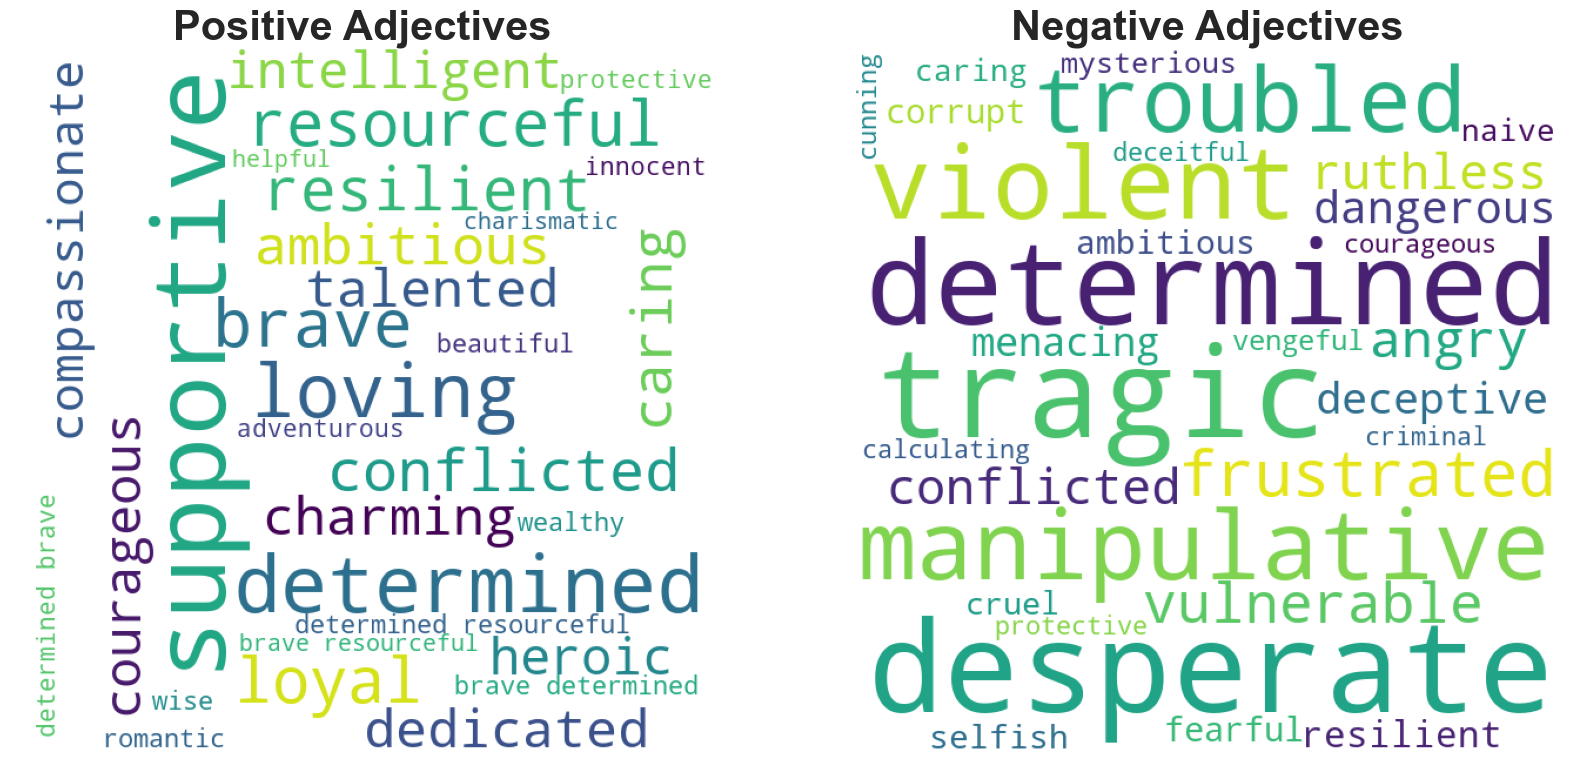

In [13]:
# Generate text for positive and negative sentiment scores
positive_text = ",".join(character_df[character_df.sentiment_score > 0.1].Adjectives)
negative_text = ",".join(character_df[character_df.sentiment_score < -0.1].Adjectives)

# Create word clouds
positive_wordcloud = WordCloud(width=600, height=600, background_color='white',
                               min_font_size=10, max_words=30).generate(positive_text)
negative_wordcloud = WordCloud(width=600, height=600, background_color='white',
                               min_font_size=10, max_words=30).generate(negative_text)

# Plot the word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(positive_wordcloud)
axes[0].set_title('Positive Adjectives', fontsize=30, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(negative_wordcloud)
axes[1].set_title('Negative Adjectives', fontsize=30, fontweight='bold')
axes[1].axis('off')

plt.show()


Box plot - no racial group stands out in terms of distribution.

<Figure size 1200x800 with 0 Axes>

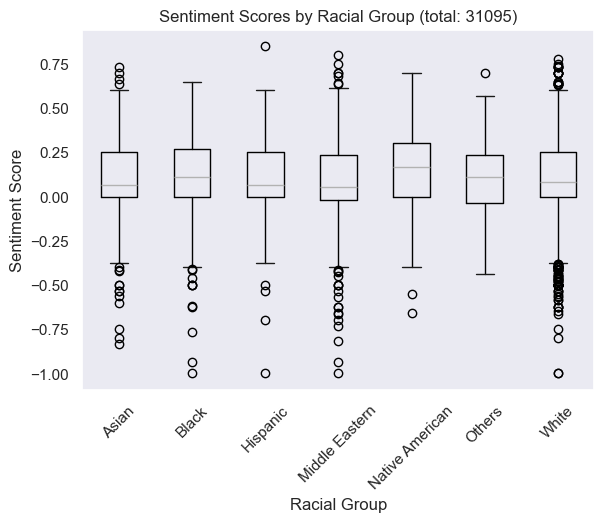

In [14]:
# Plot box plots of sentiment_score for each racial group
plt.figure(figsize=(12, 8))
character_df[character_df.is_in_franchise].dropna(subset=['sentiment_score']).boxplot(column='sentiment_score', by='racial_group', grid=False)
movie_count = len(character_df.dropna(subset=['sentiment_score']))
plt.title(f'Sentiment Scores by Racial Group (total: {movie_count})')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Racial Group')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()

## Shapley value analysis: what is the recipe for franchise movies?

In [15]:
tree_df = get_tree_df(franchise_df, movies_no_franchise_df, RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(tree_df.drop(columns=["in_franchise"]), tree_df["in_franchise"], test_size=0.3)
clf = HistGradientBoostingClassifier(max_iter=100, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
print("Test accuracy:", clf.score(X_test, y_test))

Test accuracy: 0.805439330543933


In [ ]:
run_importance(clf, X_train, X_test, y_test, target_name="in_franchise", save_dir="data/shapley_result", random_state=RANDOM_STATE)

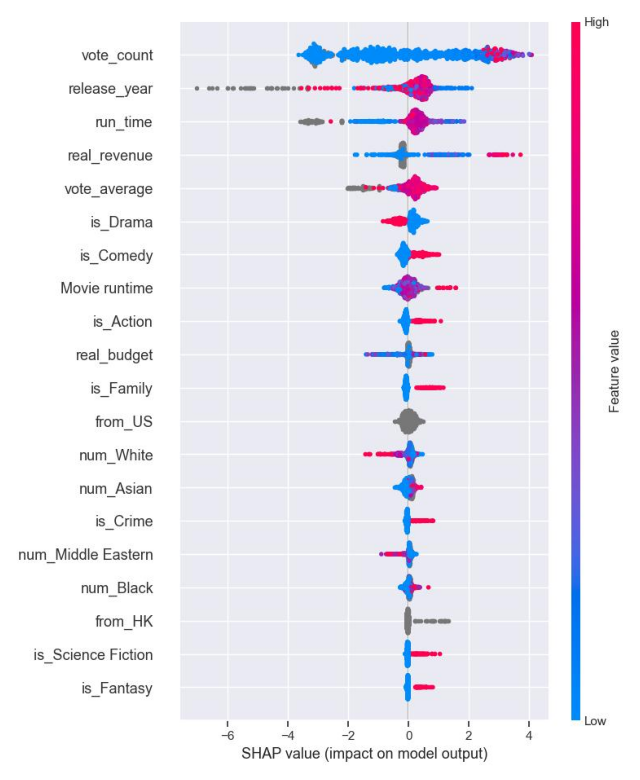

In [37]:
shap_plot = plt.imread("data/shapley_result/shap_summary_plot_in_franchise.jpg")
plt.figure(figsize=(8,10))  # Set the plot size
plt.imshow(shap_plot)
plt.axis('off')  # Hide the axis
plt.show()